# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

### Problem statement
In this capstone project, you need to create a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention
mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through 
a CNN-RNN model will be converted to speech using a text to speech library. 

This problem statement is an application of both deep learning and natural language processing. The features of an image will be extracted by a CNN-based encoder and this
will be decoded by an RNN model.

The project is an extended application of Show, Attend and Tell: Neural Image Caption Generation with Visual Attention paper.

The dataset is taken from the Kaggle website and it consists of sentence-based image descriptions having a list of 8,000 images that are each paired with five different
captions which provide clear descriptions of the salient entities and events of the image.

In [1]:
!pip install gtts playsound

  Using cached gTTS-2.3.2-py3-none-any.whl (28 kB)
  Using cached playsound-1.3.0-py3-none-any.whl
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
#Import all the required libraries
import glob
import time
import numpy as np
import seaborn as sns
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
pd.set_option('display.max_colwidth', None)
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from gtts import gTTS
from playsound import playsound
from IPython import display

[nltk_data] Downloading package stopwords to /home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [3]:
#Import the dataset and read the image into a seperate variable

images='flicker8k/Images'
all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the flicker dataset is {}".format(len(all_imgs)))

The total images present in the flicker dataset is 8091


In [4]:
# File containing captions
captions_file = "flicker8k/captions.txt"

# Read image filenames from the folder
image_filenames = [filename for filename in os.listdir(images) if filename.endswith((".jpg", ".png"))]

# Choose 5 random images
random_images = random.sample(image_filenames, 5)

# Read captions from captions file
with open(captions_file, "r") as f:
    captions = f.read().splitlines()

# Create a dictionary to store selected captions for each image
selected_captions = {}
for img in random_images:
    for caption in captions:
        parts = caption.split(",")
        if img == parts[0]:
            selected_captions.setdefault(img, []).append(parts[1])

In [5]:
selected_captions  # 5 random images with captions

{'1419286010_b59af3962a.jpg': ['A fisherman is reeling his rod while another relaxes in a boat on water .',
  'A man in a gray cap fishing .',
  'A man sits in a boat and holds a fishing pole while another lays down .',
  'a man wearing a grey hat fishing out of a fishing boat .',
  'Two men in a boat fishing .'],
 '3259991972_fce3ab18b2.jpg': ['A break dancer spins on his head outside as onlookers watch the performance .',
  'A man spinning on his head on a city sidewalk near a checkerboard mat .',
  'A man stands on his head in front of a crowd .',
  'Man standing on his head near a black and white pattern in the street .',
  'Young man break dancing in the street .'],
 '2960759328_2d31e4af9b.jpg': ['Men on horses in the rodeo try to rope in a bull .',
  'There is a cowboy in a rodeo trying to lasso a calf .',
  "Two cowboys on horses chase a young cow with lassos ' .",
  'Two cowboys riding horses attempt to rope a small cow .',
  'Two men on horses are trying to lasso a bull .'],
 

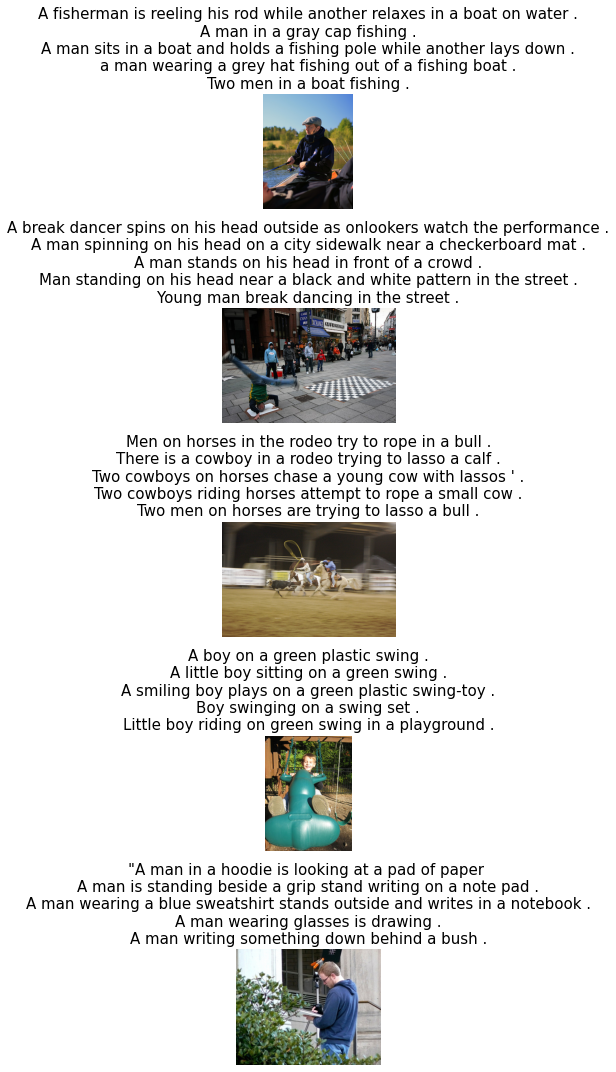

In [6]:
# Display 5 images with captions using Seaborn
fig, axes = plt.subplots(5, 1, figsize=(8, 15))

for i, (img_name, img_captions) in enumerate(selected_captions.items()):
    img_path = os.path.join(images, img_name)
    img = Image.open(img_path)
    
    axes[i].imshow(img)
    axes[i].set_title("\n".join(img_captions), fontsize=15)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [7]:
#Import the dataset and read the text file into a seperate variable
def load_doc(filename):
    with open(captions_file, "r") as f:
        text = f.read().splitlines()
    return text

doc = load_doc(captions_file)
print(doc[1:300])

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .', '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .', '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting', '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .', '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .', '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .', '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .', '1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', '

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [8]:
# creating dataframe from images and captions
all_img_id= []
all_img_vector= []
annotations= []
for id, data in enumerate(doc[1:]):
    
    all_img_id.append(id)
    all_img_vector.append(f'{images}/{data.split(",")[0]}')
    annotations.append(data.split(",")[1])
    
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df.head()

,ID,Path,Captions
0,0,flicker8k/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1,flicker8k/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,2,flicker8k/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,3,flicker8k/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,4,flicker8k/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


In [9]:
#Create a list which contains all the captions
annotations = []
for i in list(df['Captions']):
    #add the <start> & <end> token to all those captions as well
    annotations.append(f'<start> {i} <end>')
df['Captions_amended'] = annotations

#Create a list which contains all the path to the images
all_img_path=df['Path']
print("Total captions present in the dataframe is "+ str(len(annotations)))
print("Total images present in the dataframe is " + str(len(all_img_path)))

Total captions present in the dataframe is 40455
Total images present in the dataframe is 40455


In [10]:
df.head()

,ID,Path,Captions,Captions_amended
0,0,flicker8k/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>
1,1,flicker8k/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .,<start> A girl going into a wooden building . <end>
2,2,flicker8k/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,<start> A little girl climbing into a wooden playhouse . <end>
3,3,flicker8k/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .,<start> A little girl climbing the stairs to her playhouse . <end>
4,4,flicker8k/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .,<start> A little girl in a pink dress going into a wooden cabin . <end>


In [11]:
uniq_images = np.unique(df.Path.values)
print("Total unique images in dataframe are " + str(len(uniq_images)))

Total unique images in dataframe are 8091


In [12]:
#Create the vocabulary & the counter for the captions
vocabulary = []
for sent in df.Captions.values:
        vocabulary.extend(sent.split())
        
val_count = Counter(vocabulary)
print("Size of Vocab is ",len(set(vocabulary)))
print(val_count)

Size of Vocab is  9536
Counter({'a': 38716, '.': 34205, 'A': 21480, 'in': 18170, 'the': 14587, 'on': 10354, 'is': 9069, 'and': 8057, 'dog': 7804, 'with': 7303, 'man': 6727, 'of': 6495, 'Two': 3962, 'white': 3646, 'black': 3491, 'boy': 3395, 'are': 3364, 'girl': 3174, 'woman': 3146, 'to': 3005, 'The': 2919, 'wearing': 2916, 'at': 2809, 'water': 2671, 'red': 2542, 'young': 2411, 'people': 2397, 'brown': 2383, 'his': 2255, 'blue': 2116, 'dogs': 2055, 'running': 1995, 'through': 1978, 'playing': 1954, 'an': 1870, 'while': 1807, 'down': 1755, 'shirt': 1735, 'standing': 1702, 'ball': 1678, 'little': 1607, 'grass': 1565, 'child': 1449, 'snow': 1431, 'jumping': 1429, 'person': 1393, 'over': 1378, 'front': 1322, 'sitting': 1322, 'field': 1220, 'up': 1215, 'holding': 1211, 'small': 1193, '"A': 1186, 'two': 1170, 'by': 1167, 'large': 1165, 'group': 1161, 'green': 1150, 'yellow': 1143, 'walking': 1126, 'her': 1102, 'into': 1046, 'men': 1019, 'beach': 1017, 'air': 1008, 'children': 992, 'Three': 96

In [13]:
#Visualise the top 30 occuring words in the captions including stopwords
val_count.most_common(30)

[('a', 38716),
 ('.', 34205),
 ('A', 21480),
 ('in', 18170),
 ('the', 14587),
 ('on', 10354),
 ('is', 9069),
 ('and', 8057),
 ('dog', 7804),
 ('with', 7303),
 ('man', 6727),
 ('of', 6495),
 ('Two', 3962),
 ('white', 3646),
 ('black', 3491),
 ('boy', 3395),
 ('are', 3364),
 ('girl', 3174),
 ('woman', 3146),
 ('to', 3005),
 ('The', 2919),
 ('wearing', 2916),
 ('at', 2809),
 ('water', 2671),
 ('red', 2542),
 ('young', 2411),
 ('people', 2397),
 ('brown', 2383),
 ('his', 2255),
 ('blue', 2116)]

Text(0.5, 1.0, 'Top 30 words occured including stopwords')

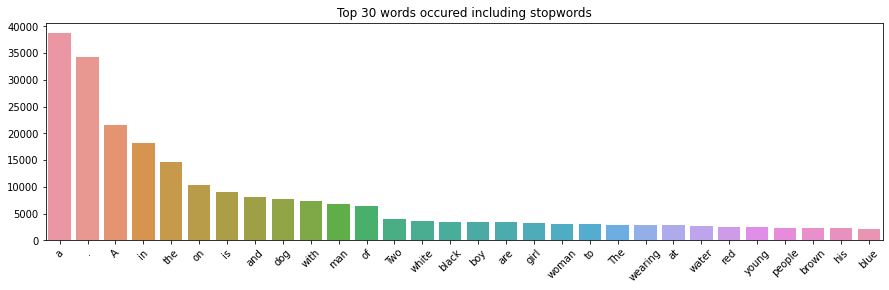

In [14]:
# top 30 words including stopwords
most_common = val_count.most_common(30)

word_list = []
word_count_list = []
for word, count in most_common:
    word_list.append(word)
    word_count_list.append(count)
plt.figure(figsize=(15,4))
plt.xticks(rotation=45)
sns.barplot(x = word_list, y = word_count_list).set_title('Top 30 words occured including stopwords')

In [15]:
#stopwords in english language and dot[.] is also added to stopwords
STOPWORDS = stopwords.words('english')
STOPWORDS.append(".")

Text(0.5, 1.0, 'Top 30 words occured excluding stopwords')

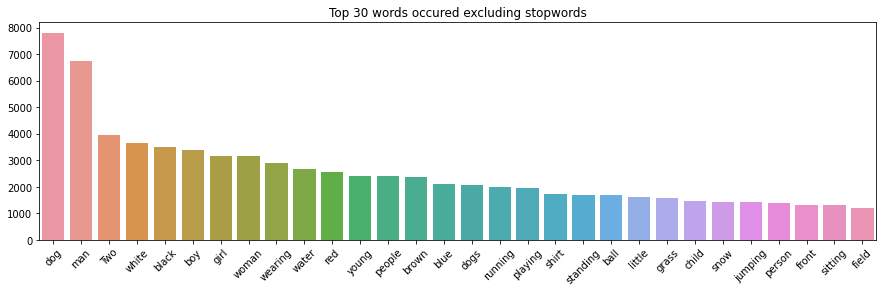

In [16]:
# visualizing top 30 words excluding stopwords
without_stopwords = {}
for word, count in val_count.items():
    if word.lower() not in STOPWORDS:
        without_stopwords[word]=count
most_common = sorted(without_stopwords.items(), key=lambda x:x[1], reverse=True)

word_list = []
word_count_list = []
for word, count in most_common[:30]:
    word_list.append(word)
    word_count_list.append(count)
plt.figure(figsize=(15,4))
plt.xticks(rotation=45)
sns.barplot(x = word_list, y = word_count_list).set_title('Top 30 words occured excluding stopwords')

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [17]:
# create the tokenizer
top_word_count = 5000

tokenizer = Tokenizer(
    num_words=top_word_count,
    filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token="UNK",
    )
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)
print(train_seqs[0],end="\n")
print(annotations[0], end='\n')
print("\n")
print(train_seqs[1],end="\n")
print(annotations[1], end='\n')
print("\n")
print(f'OOV Token: {tokenizer.oov_token}')

[3, 2, 44, 5, 2, 89, 173, 8, 116, 52, 2, 389, 13, 385, 5, 29, 1, 670, 4]
<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>


[3, 2, 20, 313, 64, 2, 197, 120, 4]
<start> A girl going into a wooden building . <end>


OOV Token: UNK


In [18]:
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

In [19]:
# Create word-to-index and index-to-word mappings.
word_index = tokenizer.word_index
index_word = tokenizer.index_word

In [20]:
word_index

{'UNK': 1,
 'a': 2,
 '<start>': 3,
 '<end>': 4,
 'in': 5,
 'the': 6,
 'on': 7,
 'is': 8,
 'and': 9,
 'dog': 10,
 'with': 11,
 'man': 12,
 'of': 13,
 'two': 14,
 'white': 15,
 'black': 16,
 'boy': 17,
 'are': 18,
 'woman': 19,
 'girl': 20,
 'to': 21,
 'wearing': 22,
 'people': 23,
 'at': 24,
 'water': 25,
 'young': 26,
 'red': 27,
 'brown': 28,
 'an': 29,
 'his': 30,
 'blue': 31,
 'dogs': 32,
 'running': 33,
 'through': 34,
 'playing': 35,
 'shirt': 36,
 'while': 37,
 'down': 38,
 'little': 39,
 'standing': 40,
 'ball': 41,
 'grass': 42,
 'person': 43,
 'child': 44,
 'snow': 45,
 'jumping': 46,
 'over': 47,
 'three': 48,
 'front': 49,
 'sitting': 50,
 'small': 51,
 'up': 52,
 'field': 53,
 'holding': 54,
 'large': 55,
 'group': 56,
 'by': 57,
 'green': 58,
 'yellow': 59,
 'children': 60,
 'walking': 61,
 'men': 62,
 'her': 63,
 'into': 64,
 'beach': 65,
 'air': 66,
 'near': 67,
 'jumps': 68,
 'mouth': 69,
 'street': 70,
 'runs': 71,
 'for': 72,
 'another': 73,
 'riding': 74,
 'from': 75

Text(0.5, 1.0, 'Top 30 words occured in tokeniser')

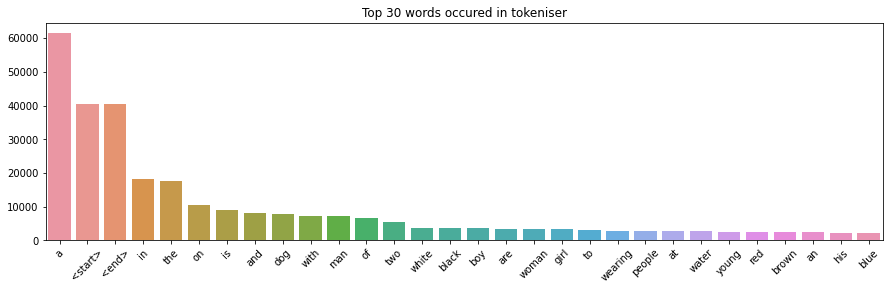

In [21]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
sort_word_by_count = sorted(tokenizer.word_counts.items(), key=lambda kv : kv[1], reverse= True)

word_list = []
word_count_list = []
for word, count in sort_word_by_count[:30]:
    word_list.append(word)
    word_count_list.append(count)
plt.figure(figsize=(15,4))
plt.xticks(rotation=45)
sns.barplot(x = word_list, y = word_count_list).set_title('Top 30 words occured in tokeniser')

In [22]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

# Get max training sequence length
max_length = max([len(x) for x in train_seqs])

# Pad the training sequences
cap_vector = pad_sequences(train_seqs, padding='post', truncating='post', maxlen=max_length)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 35)


In [23]:
print(cap_vector[0],end="\n")
print(annotations[0], end='\n')

[  3   2  44   5   2  89 173   8 116  52   2 389  13 385   5  29   1 670
   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>


In [24]:
# Save Tokenizer
import pickle
with open('tokenizer.pkl',"wb") as f:
    pickle.dump(tokenizer,f)

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [25]:
#write your code here to create the dataset consisting of image paths
image_paths_dataset = tf.data.Dataset.from_tensor_slices(all_imgs)

2023-08-29 02:55:40.957940: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-29 02:55:40.958008: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


In [26]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
    # Read the image file
    img = tf.io.read_file(image_path)
    # Decode the image as a JPEG file (you can adjust this depending on your image format)
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image to the input size required by InceptionV3
    img = tf.image.resize(img, (299, 299)) 
    # Normalize the image within the range of -1 to 1 for the InceptionV3 model
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [27]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path

# Apply the preprocessing function to each image path
preprocessed_images_dataset = image_paths_dataset.map(load_image)

# For batching:
batch_size = 32  # Adjust as needed
batched_dataset = preprocessed_images_dataset.batch(batch_size)

In [28]:
batched_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [29]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input                    #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output     #write code here to get the output of the image_model

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)   #build the final model using both input & output layer

In [30]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

In [31]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
image_features_dict={}
for img, path in tqdm(batched_dataset):
  #PARSING IMAGES THROUGH INCEPTIONv3 MODEL
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

  for batch_feat, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    image_features_dict[path_of_feature] =  batch_feat.numpy()

100%|██████████| 253/253 [00:33<00:00,  7.50it/s]


In [32]:
list(image_features_dict.items())[0]

('flicker8k/Images/3428386573_670f5362f0.jpg',
 array([[0.        , 0.        , 0.5087082 , ..., 0.        , 0.03438612,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.31656572,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.3096229 ,
         0.        ],
        ...,
        [0.        , 3.252658  , 0.        , ..., 0.        , 0.        ,
         1.3762631 ],
        [0.        , 1.9786698 , 0.        , ..., 0.        , 0.        ,
         0.7556032 ],
        [0.        , 0.4061239 , 0.        , ..., 0.        , 0.        ,
         0.5091566 ]], dtype=float32))

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [33]:
#write your code here
# train- test split in 80:20 ratio
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector, cap_vector,test_size=0.2,random_state=100)

In [34]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [35]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.
def map_func(image, caption):
    image_final = image_features_dict[image.decode('utf-8')]
    return image_final,caption


### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [36]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(image, caption, batch_size = 32,buffer_size=1000):
    
    dataset = tf.data.Dataset.from_tensor_slices((image, caption))

    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
            num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffling and batch
    dataset = dataset.shuffle(buffer_size).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [37]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [38]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 35)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [39]:
# Setting the parameters
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // batch_size
test_num_steps = len(path_test) // batch_size

max_length=max_length
features_shape = batch_feat.shape[1]
attention_features_shape = batch_feat.shape[0]

### Encoder

In [40]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim,activation="relu") #build your Dense layer with relu activation
        #It acts as the fully connected layer
        
    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0) #applying relu activation 
        return features

In [41]:
encoder=Encoder(embedding_dim)

### Attention model

In [42]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 =  tf.keras.layers.Dense(units)#build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis=hidden[:, tf.newaxis] # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score =tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)# reduce the shape to (batch_size, embedding_dim)
        # the tensor is reduced along the second dimension (columns)

        return context_vector, attention_weights

### Decoder

In [43]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)   #build your Dense layer

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)#create your context vector & attention weights from attention model
        embed = self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [44]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [45]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [46]:
#define the optimizer
optimizer = tf.keras.optimizers.Adam()
#define your loss object
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [47]:
# defining loss function
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask # we are multiplying loss with mask to get ideal shape

    return tf.reduce_mean(loss_)

In [48]:
# creating checkpoint
checkpoint_path_ckpt = os.path.join("checkpoint","train")
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [49]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [50]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: #Record operations for automatic differentiation for implementing backpropagation
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)

          loss += loss_function(target[:, t], predictions)

          dec_input = tf.expand_dims(target[:, t], 1)
    
    avg_loss = (loss / int(target.shape[1])) #we are calculating average loss for every batch

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables
    
    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables)) 
        
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [51]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: #Record operations for automatic differentiation.
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder.
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)

          loss += loss_function(target[:, t], predictions) 

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, t], 1)
    
    avg_loss = (loss / int(target.shape[1]))#we are calculating average loss for every batch

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables

    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables))
        
    return loss, avg_loss

In [52]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss / test_num_steps
    
    return avg_test_loss

In [53]:
loss_plot = []
test_loss_plot = []
EPOCHS = 30

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  3%|▎         | 1/30 [03:36<1:44:27, 216.12s/it]

For epoch: 1, the train loss is 1.271, & test loss is 1.065
Time taken for 1 epoch 215.966650724411 sec

Test loss has been reduced from 100.000 to 1.065


  7%|▋         | 2/30 [05:19<1:09:51, 149.71s/it]

For epoch: 2, the train loss is 0.993, & test loss is 0.941
Time taken for 1 epoch 103.02950310707092 sec

Test loss has been reduced from 1.065 to 0.941


 10%|█         | 3/30 [07:02<57:44, 128.33s/it]  

For epoch: 3, the train loss is 0.901, & test loss is 0.865
Time taken for 1 epoch 102.71419739723206 sec

Test loss has been reduced from 0.941 to 0.865


 13%|█▎        | 4/30 [08:45<51:18, 118.39s/it]

For epoch: 4, the train loss is 0.834, & test loss is 0.807
Time taken for 1 epoch 102.95976781845093 sec

Test loss has been reduced from 0.865 to 0.807


 17%|█▋        | 5/30 [10:28<47:01, 112.84s/it]

For epoch: 5, the train loss is 0.779, & test loss is 0.757
Time taken for 1 epoch 102.85510659217834 sec

Test loss has been reduced from 0.807 to 0.757


 20%|██        | 6/30 [12:12<43:56, 109.86s/it]

For epoch: 6, the train loss is 0.731, & test loss is 0.711
Time taken for 1 epoch 103.88705897331238 sec

Test loss has been reduced from 0.757 to 0.711


 23%|██▎       | 7/30 [13:57<41:32, 108.38s/it]

For epoch: 7, the train loss is 0.688, & test loss is 0.670
Time taken for 1 epoch 105.1498749256134 sec

Test loss has been reduced from 0.711 to 0.670


 27%|██▋       | 8/30 [15:43<39:26, 107.56s/it]

For epoch: 8, the train loss is 0.650, & test loss is 0.632
Time taken for 1 epoch 105.62962627410889 sec

Test loss has been reduced from 0.670 to 0.632


 30%|███       | 9/30 [17:32<37:46, 107.93s/it]

For epoch: 9, the train loss is 0.614, & test loss is 0.599
Time taken for 1 epoch 108.57504606246948 sec

Test loss has been reduced from 0.632 to 0.599


 33%|███▎      | 10/30 [19:20<35:57, 107.85s/it]

For epoch: 10, the train loss is 0.582, & test loss is 0.566
Time taken for 1 epoch 107.5078957080841 sec

Test loss has been reduced from 0.599 to 0.566
For epoch: 11, the train loss is 0.553, & test loss is 0.539
Time taken for 1 epoch 106.9786548614502 sec

Test loss has been reduced from 0.566 to 0.539


 40%|████      | 12/30 [22:53<32:08, 107.13s/it]

For epoch: 12, the train loss is 0.526, & test loss is 0.513
Time taken for 1 epoch 105.77272629737854 sec

Test loss has been reduced from 0.539 to 0.513


 43%|████▎     | 13/30 [24:36<30:01, 105.99s/it]

For epoch: 13, the train loss is 0.501, & test loss is 0.490
Time taken for 1 epoch 103.20192861557007 sec

Test loss has been reduced from 0.513 to 0.490


 47%|████▋     | 14/30 [26:20<28:04, 105.29s/it]

For epoch: 14, the train loss is 0.483, & test loss is 0.470
Time taken for 1 epoch 103.48020887374878 sec

Test loss has been reduced from 0.490 to 0.470


 50%|█████     | 15/30 [28:02<26:04, 104.28s/it]

For epoch: 15, the train loss is 0.461, & test loss is 0.453
Time taken for 1 epoch 101.78462266921997 sec

Test loss has been reduced from 0.470 to 0.453


 53%|█████▎    | 16/30 [29:45<24:16, 104.05s/it]

For epoch: 16, the train loss is 0.442, & test loss is 0.434
Time taken for 1 epoch 103.35720372200012 sec

Test loss has been reduced from 0.453 to 0.434
For epoch: 17, the train loss is 0.426, & test loss is 0.419
Time taken for 1 epoch 102.4901967048645 sec

Test loss has been reduced from 0.434 to 0.419


 60%|██████    | 18/30 [33:15<20:55, 104.59s/it]

For epoch: 18, the train loss is 0.411, & test loss is 0.405
Time taken for 1 epoch 106.63880825042725 sec

Test loss has been reduced from 0.419 to 0.405


 63%|██████▎   | 19/30 [35:00<19:11, 104.69s/it]

For epoch: 19, the train loss is 0.398, & test loss is 0.393
Time taken for 1 epoch 104.73870992660522 sec

Test loss has been reduced from 0.405 to 0.393


 67%|██████▋   | 20/30 [36:44<17:26, 104.67s/it]

For epoch: 20, the train loss is 0.385, & test loss is 0.378
Time taken for 1 epoch 104.44496631622314 sec

Test loss has been reduced from 0.393 to 0.378


 70%|███████   | 21/30 [38:29<15:41, 104.59s/it]

For epoch: 21, the train loss is 0.373, & test loss is 0.367
Time taken for 1 epoch 104.24676704406738 sec

Test loss has been reduced from 0.378 to 0.367


 73%|███████▎  | 22/30 [40:14<13:57, 104.70s/it]

For epoch: 22, the train loss is 0.364, & test loss is 0.358
Time taken for 1 epoch 104.78649735450745 sec

Test loss has been reduced from 0.367 to 0.358


 77%|███████▋  | 23/30 [41:58<12:12, 104.68s/it]

For epoch: 23, the train loss is 0.354, & test loss is 0.347
Time taken for 1 epoch 104.4484052658081 sec

Test loss has been reduced from 0.358 to 0.347


 80%|████████  | 24/30 [43:43<10:27, 104.61s/it]

For epoch: 24, the train loss is 0.347, & test loss is 0.338
Time taken for 1 epoch 104.28750014305115 sec

Test loss has been reduced from 0.347 to 0.338


 83%|████████▎ | 25/30 [45:29<08:45, 105.15s/it]

For epoch: 25, the train loss is 0.338, & test loss is 0.331
Time taken for 1 epoch 106.23336982727051 sec

Test loss has been reduced from 0.338 to 0.331


 87%|████████▋ | 26/30 [47:12<06:58, 104.59s/it]

For epoch: 26, the train loss is 0.329, & test loss is 0.324
Time taken for 1 epoch 103.12675285339355 sec

Test loss has been reduced from 0.331 to 0.324
For epoch: 27, the train loss is 0.321, & test loss is 0.318
Time taken for 1 epoch 103.20341920852661 sec

Test loss has been reduced from 0.324 to 0.318


 93%|█████████▎| 28/30 [50:38<03:27, 103.70s/it]

For epoch: 28, the train loss is 0.317, & test loss is 0.309
Time taken for 1 epoch 102.27227449417114 sec

Test loss has been reduced from 0.318 to 0.309


 97%|█████████▋| 29/30 [52:27<01:45, 105.11s/it]

For epoch: 29, the train loss is 0.309, & test loss is 0.306
Time taken for 1 epoch 108.24088907241821 sec

Test loss has been reduced from 0.309 to 0.306
For epoch: 30, the train loss is 0.305, & test loss is 0.297
Time taken for 1 epoch 112.66568183898926 sec

Test loss has been reduced from 0.306 to 0.297


100%|██████████| 30/30 [54:19<00:00, 108.66s/it]


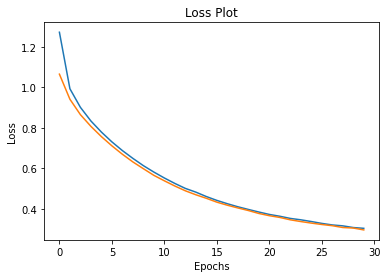

In [54]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

In [55]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [56]:
from nltk.translate.bleu_score import sentence_bleu

In [57]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [58]:
# making a copy of test data
img_test=path_test.copy()

### Greedy Search

In [59]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    #hidden = decoder.reset_state(batch_size=1)
    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id =  tf.argmax(predictions[0]).numpy()#extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])#map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


BELU score: 40.8248290463863
Real Caption: a group of little girls wearing headscarfs pose for a group picture
Prediction Caption: a group of african children in african american woman wearing headscarfs pose for the camera


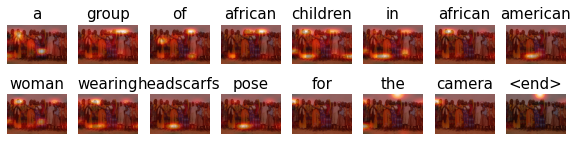

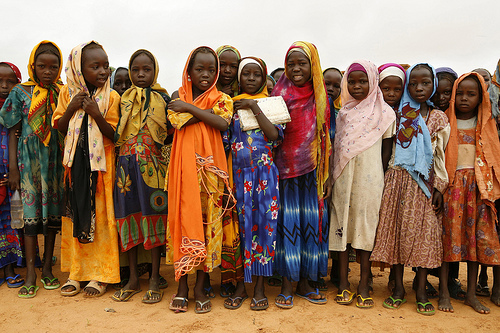

In [69]:
weights=(0.5, 0.5, 0, 0)
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)

real_caption=filt_text(real_caption)      

pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=weights)
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [75]:
captions=evaluate(test_image)
print(captions)

(['a', 'group', 'of', 'african', 'children', 'in', 'african', 'american', 'woman', 'wearing', 'headscarfs', 'pose', 'for', 'the', 'camera', '<end>'], array([[9.11549364e-07, 1.53105520e-05, 3.55781778e-03, ...,
        3.47343768e-04, 3.10999458e-05, 3.32614407e-04],
       [1.26593611e-10, 7.39847028e-09, 2.53759680e-07, ...,
        1.41885943e-08, 1.44237790e-11, 5.97496230e-09],
       [1.53769331e-10, 1.16354515e-09, 4.57098004e-08, ...,
        1.17963428e-09, 1.09727635e-11, 3.85992516e-10],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]), <tf.Tensor: shape=(1, 5001), dtype=float32, numpy=
array([[-19.005245 ,  10.880718 ,   3.7663283, ..., -14.627042 ,
        -11.

In [76]:
#Let's use Google Text to Speech Online API from playing the predicted caption as audio
text = " ".join(captions[0][0:-1])
speech = gTTS("Caption is : "+ text,lang = 'en', slow = False) 
speech.save('caption.mp3')
audio_file = 'caption.mp3'
#playsound('voice.wav')
display.display(display.Audio(audio_file, rate=None,autoplay=False))

### Beam Search(optional)

In [72]:
def beam_evaluate(image, beam_index = 1):
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption


a group of african children in african american woman wearing headscarfs pose for the camera


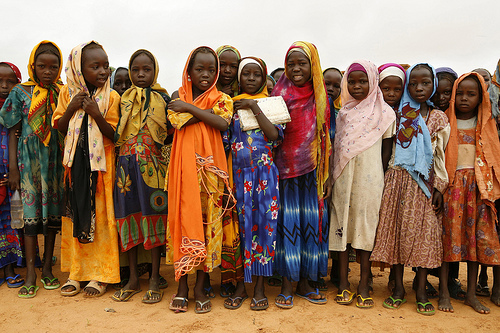

In [77]:
captions=beam_evaluate(test_image)
print(captions)
Image.open(test_image)

In [78]:
#Let's use Google Text to Speech Online API from playing the predicted caption as audio
speech = gTTS("caption is: "+ captions,lang = 'en', slow = False) 
speech.save('caption.mp3')
audio_file = 'caption.mp3'
#playsound('voice.wav')
display.display(display.Audio(audio_file, rate=None,autoplay=False))